In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import math


import os
import glob
from PIL import Image
import numpy as np
import pandas as pd
from natsort import natsorted
from tqdm import tqdm

import matplotlib.pyplot as plt

# Complex Utils and UNET

In [2]:
def apply_complex(fr, fi, input, dtype= torch.complex64):
    return (fr(input.real) - fi(input.imag)) + 1j * (fr(input.imag) + fi(input.real))



class ComplexConv2d(nn.Module):
    def __init__(self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=1,
        bias: bool = False,
        complex_axis= 1,
        device= None,
        dtype= None
        ) -> None:
        super().__init__()

        self.conv_real = nn.Conv2d(in_channels, out_channels, kernel_size= kernel_size, stride= stride, padding= padding,  bias= bias)
        self.conv_imag = nn.Conv2d(in_channels, out_channels, kernel_size= kernel_size, stride= stride, padding= padding,  bias= bias)



    def forward(self, x):
        ''' define how the forward prop will take place '''
        # check if the input is of dtype complex
        # for this we can use is_complex() function which will return true if the input is complex dtype
        if not x.is_complex():
            raise ValueError(f"Input should be a complex tensor. Got {x.dtype}")

        return apply_complex(self.conv_real, self.conv_imag, x)
    

class ComplexTranspose2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size,
        stride=1,
        padding=0,
        output_padding=0,
        bias: bool= False,
        device= None,
        dtype= None
    ):
        super().__init__()

        self.trans_conv_real = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride= stride, padding= padding, output_padding= output_padding,  bias= bias)
        self.trans_conv_imag = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride= stride, padding= padding, output_padding= output_padding,  bias= bias)

    def forward(self, x):
        ''' define how the forward prop will take place '''
        # check if the input is of dtype complex
        if not x.is_complex():
            raise ValueError(f"Input should be a complex tensor. Got {x.dtype}")

        return apply_complex(self.trans_conv_real, self.trans_conv_imag, x)
    

class ComplexMaxPool2d(nn.Module):

    def __init__(self, kernel_size, stride= 2, padding= 0, dilation=(1,1), return_indices= False, ceil_mode= False):
        super().__init__()

        self.kernel_size= kernel_size
        self.stride = stride
        self.padding= padding
        self.dilation = dilation
        self.ceil_mode= ceil_mode
        self.return_indices= return_indices

        self.max_pool = nn.MaxPool2d(self.kernel_size, self.stride, self.padding, self.dilation, 
                                     self.return_indices, self.ceil_mode)

    def forward(self, x):

        # check if the input is complex
        if not x.is_complex():
            raise ValueError(f"Input should be a complex tensor, Got {x.dtype}")

        return (self.max_pool(x.real)) + 1j * (self.max_pool(x.imag))
    

class CReLU(nn.Module):
    """
    remove self.real_coeff and self.imag_coeff if not needed
    """
    def __init__(self):
        super().__init__()
        self.real_coeff = nn.Parameter(torch.tensor(1.0))
        self.imag_coeff = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        real_part = F.relu(self.real_coeff*x.real)
        imag_part = F.relu(self.imag_coeff*x.imag)
        return real_part + 1j * imag_part
    


class Naive_ComplexSigmoid(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.sigmoid(x.real) + 1j * F.sigmoid(x.imag)
    




class ComplexBatchNorm2d(torch.nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True,
            track_running_stats=True, complex_axis=1):
        super().__init__()
        self.num_features        = num_features
        self.eps                 = eps
        self.momentum            = momentum
        self.affine              = affine
        self.track_running_stats = track_running_stats

        self.complex_axis = complex_axis

        if self.affine:
            self.Wrr = torch.nn.Parameter(torch.Tensor(self.num_features))
            self.Wri = torch.nn.Parameter(torch.Tensor(self.num_features))
            self.Wii = torch.nn.Parameter(torch.Tensor(self.num_features))
            self.Br  = torch.nn.Parameter(torch.Tensor(self.num_features))
            self.Bi  = torch.nn.Parameter(torch.Tensor(self.num_features))
        else:
            self.register_parameter('Wrr', None)
            self.register_parameter('Wri', None)
            self.register_parameter('Wii', None)
            self.register_parameter('Br',  None)
            self.register_parameter('Bi',  None)

        if self.track_running_stats:
            self.register_buffer('RMr',  torch.zeros(self.num_features))
            self.register_buffer('RMi',  torch.zeros(self.num_features))
            self.register_buffer('RVrr', torch.ones (self.num_features))
            self.register_buffer('RVri', torch.zeros(self.num_features))
            self.register_buffer('RVii', torch.ones (self.num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('RMr',                 None)
            self.register_parameter('RMi',                 None)
            self.register_parameter('RVrr',                None)
            self.register_parameter('RVri',                None)
            self.register_parameter('RVii',                None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.RMr.zero_()
            self.RMi.zero_()
            self.RVrr.fill_(1)
            self.RVri.zero_()
            self.RVii.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.Br.data.zero_()
            self.Bi.data.zero_()
            self.Wrr.data.fill_(1)
            self.Wri.data.uniform_(-.9, +.9) # W will be positive-definite
            self.Wii.data.fill_(1)

    def _check_input_dim(self, xr, xi):
        assert(xr.shape == xi.shape)
        assert(xr.size(1) == self.num_features)

    def forward(self, inputs):
        #self._check_input_dim(xr, xi)

        # xr, xi = torch.chunk(inputs,2, axis=self.complex_axis)
        xr, xi = inputs.real, inputs.imag
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        #
        # NOTE: The precise meaning of the "training flag" is:
        #       True:  Normalize using batch   statistics, update running statistics
        #              if they are being collected.
        #       False: Normalize using running statistics, ignore batch   statistics.
        #
        training = self.training or not self.track_running_stats
        redux = [i for i in reversed(range(xr.dim())) if i!=1]
        vdim  = [1] * xr.dim()
        vdim[1] = xr.size(1)

        #
        # Mean M Computation and Centering
        #
        # Includes running mean update if training and running.
        #
        if training:
            Mr, Mi = xr, xi
            for d in redux:
                Mr = Mr.mean(d, keepdim=True)
                Mi = Mi.mean(d, keepdim=True)
            if self.track_running_stats:
                self.RMr.lerp_(Mr.squeeze(), exponential_average_factor)
                self.RMi.lerp_(Mi.squeeze(), exponential_average_factor)
        else:
            Mr = self.RMr.view(vdim)
            Mi = self.RMi.view(vdim)
        xr, xi = xr-Mr, xi-Mi

        #
        # Variance Matrix V Computation
        #
        # Includes epsilon numerical stabilizer/Tikhonov regularizer.
        # Includes running variance update if training and running.
        #
        if training:
            Vrr = xr * xr
            Vri = xr * xi
            Vii = xi * xi
            for d in redux:
                Vrr = Vrr.mean(d, keepdim=True)
                Vri = Vri.mean(d, keepdim=True)
                Vii = Vii.mean(d, keepdim=True)
            if self.track_running_stats:
                self.RVrr.lerp_(Vrr.squeeze(), exponential_average_factor)
                self.RVri.lerp_(Vri.squeeze(), exponential_average_factor)
                self.RVii.lerp_(Vii.squeeze(), exponential_average_factor)
        else:
            Vrr = self.RVrr.view(vdim)
            Vri = self.RVri.view(vdim)
            Vii = self.RVii.view(vdim)
        Vrr   = Vrr + self.eps
        Vri   = Vri
        Vii   = Vii + self.eps

        #
        # Matrix Inverse Square Root U = V^-0.5
        #
        # sqrt of a 2x2 matrix,
        # - https://en.wikipedia.org/wiki/Square_root_of_a_2_by_2_matrix
        tau   = Vrr + Vii
        # delta = torch.addcmul(Vrr * Vii, -1, Vri, Vri)
        delta = torch.addcmul(Vrr * Vii, Vri, Vri, value= -1)
        s     = delta.sqrt()
        t     = (tau + 2*s).sqrt()

        # matrix inverse, http://mathworld.wolfram.com/MatrixInverse.html
        rst   = (s * t).reciprocal()
        Urr   = (s + Vii) * rst
        Uii   = (s + Vrr) * rst
        Uri   = (  - Vri) * rst

        #
        # Optionally left-multiply U by affine weights W to produce combined
        # weights Z, left-multiply the inputs by Z, then optionally bias them.
        #
        # y = Zx + B
        # y = WUx + B
        # y = [Wrr Wri][Urr Uri] [xr] + [Br]
        #     [Wir Wii][Uir Uii] [xi]   [Bi]
        #
        if self.affine:
            Wrr, Wri, Wii = self.Wrr.view(vdim), self.Wri.view(vdim), self.Wii.view(vdim)
            Zrr = (Wrr * Urr) + (Wri * Uri)
            Zri = (Wrr * Uri) + (Wri * Uii)
            Zir = (Wri * Urr) + (Wii * Uri)
            Zii = (Wri * Uri) + (Wii * Uii)
        else:
            Zrr, Zri, Zir, Zii = Urr, Uri, Uri, Uii

        yr = (Zrr * xr) + (Zri * xi)
        yi = (Zir * xr) + (Zii * xi)

        if self.affine:
            yr = yr + self.Br.view(vdim)
            yi = yi + self.Bi.view(vdim)

        return (yr) + 1j * (yi)

In [3]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            ComplexConv2d(in_channels, out_channels, kernel_size=3, bias=False),
            ComplexBatchNorm2d(out_channels),
            CReLU(),
            ComplexConv2d(out_channels, out_channels, kernel_size=3, bias=False),
            ComplexBatchNorm2d(out_channels),
            CReLU(),
        )

    def forward(self, x):
        return self.conv(x)
    

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups=nn.ModuleList()
        self.downs=nn.ModuleList()
        self.pool=ComplexMaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels=feature

        
        for feature in reversed(features):
            self.ups.append(
                ComplexTranspose2d(
                feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))
        

        self.bottleneck=DoubleConv(features[-1], features[-1]*2)
        self.final_conv=ComplexConv2d(features[0], out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x=down(x)
            skip_connections.append(x)
            x=self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverses order

        for idx in range(0, len(self.ups), 2):
            x=self.ups[idx](x)
            skip_connection=skip_connections[idx//2]

            # if x.shape != skip_connection.shape:
            #     x=TF.resize(x, size=skip_connection.shape[2:])

            concat_skip=torch.cat((skip_connection, x), dim=1)
            x=self.ups[idx+1](concat_skip)
        
        return self.final_conv(x)

# Dataset

In [4]:
class CamVid_Simple(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.files = glob.glob(path+'/*.pth')
        

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        data = torch.load(self.files[index])
        return data['img'], data['mask']  

# Analysis Part

## Check outputs of models

### L_ce loss only

In [ ]:
os.makedirs('Images', exist_ok=True)
fpath = 'Dataset/Complex_CamVid_iHSV/test'
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

testdataset = CamVid_Simple(path = fpath)
indices = np.random.randint(0,len(testdataset), 3)
model = UNET(out_channels=32, in_channels=3)
model.load_state_dict(torch.load('models/complex_model_l1_param_0.34.pth', map_location='cpu')) ## Sample model path.. 
                                                                                                ## Change accordingly
model.to(device)


plt.figure(figsize=(20,10))
df = pd.read_csv('CamVid/class_dict.csv')
color_map = df[['r', 'g', 'b']].values

indices = np.load('indices.npy')[:3]
for i,idx in tqdm(enumerate(indices), total=3):
    img = testdataset[idx][0]
    mask = testdataset[idx][1]
    out = model(img.to(device).unsqueeze(0)).detach().cpu()
    real = out.real.float()
    imag = out.imag.float()
    real = torch.argmax(real, dim=1)
    imag = torch.argmax(imag, dim=1)
    out = torch.argmax(out.real*out.imag, dim=1)
    out = color_map[out]
    imag = color_map[imag]
    real = color_map[real]
    mask = color_map[mask]

    plt.subplot(3,6,6*i+1)
    plt.imshow(img.real.squeeze().permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title('Re(Input)')
    
    plt.subplot(3,6,6*i+2)
    plt.imshow(img.imag.squeeze().permute(1,2,0))
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Im(Input)')
    
    plt.subplot(3,6,6*i+3)
    plt.imshow(mask.squeeze())
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Target')
    plt.subplot(3,6,6*i+4)
    a = plt.imshow(real.squeeze().mean(axis=-1), cmap='jet')
    plt.colorbar(a)
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Re(Output)')
        
    plt.subplot(3,6,6*i+5)
    b = plt.imshow(imag.squeeze().mean(axis=-1), cmap='jet')
    plt.colorbar(b)
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Im(Output)')
    plt.subplot(3,6,6*i+6)
    plt.imshow(out.squeeze())
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title('Output')


plt.savefig('Images/Complex_Model_l1_0.34.png')
plt.show()

### L_ce + L_phase

In [ ]:
os.makedirs('Images', exist_ok=True)
fpath = 'Dataset/Complex_CamVid_iHSV/test'
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

testdataset = CamVid_Simple(path = fpath)
indices = np.random.randint(0,len(testdataset), 3)
model = UNET(out_channels=32, in_channels=3)
model.load_state_dict(torch.load('models/complex_model_l2_param_0.36.pth', map_location='cpu')) ## Sample model path.. 
                                                                                                ## Change accordingly
model.to(device)


plt.figure(figsize=(20,10))
df = pd.read_csv('CamVid/class_dict.csv')
color_map = df[['r', 'g', 'b']].values

indices = np.load('indices.npy')[:3]
for i,idx in tqdm(enumerate(indices), total=3):
    img = testdataset[idx][0]
    mask = testdataset[idx][1]
    out = model(img.to(device).unsqueeze(0)).detach().cpu()
    real = out.real.float()
    imag = out.imag.float()
    real = torch.argmax(real, dim=1)
    imag = torch.argmax(imag, dim=1)
    out = torch.argmax(torch.abs(out), dim=1)
    out = color_map[out]
    imag = color_map[imag]
    real = color_map[real]
    mask = color_map[mask]

    plt.subplot(3,6,6*i+1)
    plt.imshow(img.real.squeeze().permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title('Re(Input)')
    
    plt.subplot(3,6,6*i+2)
    plt.imshow(img.imag.squeeze().permute(1,2,0))
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Im(Input)')
    
    plt.subplot(3,6,6*i+3)
    plt.imshow(mask.squeeze())
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Target')
    plt.subplot(3,6,6*i+4)
    a = plt.imshow(real.squeeze().mean(axis=-1), cmap='jet')
    plt.colorbar(a)
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Re(Output)')
        
    plt.subplot(3,6,6*i+5)
    b = plt.imshow(imag.squeeze().mean(axis=-1), cmap='jet')
    plt.colorbar(b)
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Im(Output)')
    plt.subplot(3,6,6*i+6)
    plt.imshow(out.squeeze())
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title('Output')


plt.savefig('Images/Complex_Model_l1_0.34.png')
plt.show()

## Visualize C_ReLU coefficients

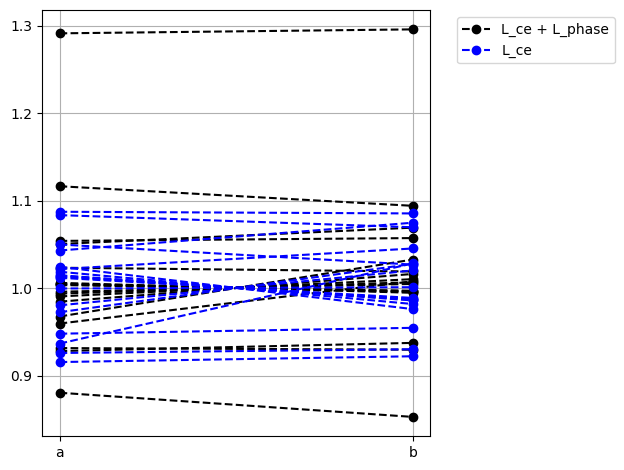

In [9]:
model = UNET(out_channels=32, in_channels=3)
model.load_state_dict(torch.load('models/complex_model_l1_param_0.35.pth', map_location='cpu'))
from collections import defaultdict

coeff_dict = defaultdict(lambda: [None, None])

for name, param in model.named_parameters():
    if name.endswith("real_coeff"):
        base = name.rsplit(".", 1)[0]
        coeff_dict[base][0] = param.item()
    elif name.endswith("imag_coeff"):
        base = name.rsplit(".", 1)[0]
        coeff_dict[base][1] = param.item()

# optional: convert to regular dict
coeff_dict = dict(coeff_dict)
for key, value in coeff_dict.items():
    plt.plot([1,1.2], value, 'ko--', label='L_ce + L_phase')

model = UNET(out_channels=32, in_channels=3)
model.load_state_dict(torch.load('models/complex_model_l2_param_0.34.pth', map_location='cpu'))
from collections import defaultdict

coeff_dict = defaultdict(lambda: [None, None])  # [real, imag]

for name, param in model.named_parameters():
    if name.endswith("real_coeff"):
        base = name.rsplit(".", 1)[0]
        coeff_dict[base][0] = param.item()
    elif name.endswith("imag_coeff"):
        base = name.rsplit(".", 1)[0]
        coeff_dict[base][1] = param.item()

# optional: convert to regular dict
coeff_dict = dict(coeff_dict)
for key, value in coeff_dict.items():
    plt.plot([1,1.2], value, 'bo--', label='L_ce')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks([1,1.2], ['a', 'b'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Images/Compare_params.png')
plt.show()

# Baseline Analysis Parts

## UNET

In [10]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)
    

class Simple_UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(Simple_UNET, self).__init__()
        self.ups=nn.ModuleList()
        self.downs=nn.ModuleList()
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels=feature

        
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))
        

        self.bottleneck=DoubleConv(features[-1], features[-1]*2)
        self.final_conv=nn.Conv2d(features[0], out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x=down(x)
            skip_connections.append(x)
            x=self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverses order

        for idx in range(0, len(self.ups), 2):
            x=self.ups[idx](x)
            skip_connection=skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x=TF.resize(x, size=skip_connection.shape[2:])

            concat_skip=torch.cat((skip_connection, x), dim=1)
            x=self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
import matplotlib.pyplot as plt
testdataset = CamVid_Simple(path = 'Dataset/CamVid_RGB/test')
model = Simple_UNET(out_channels=32, in_channels=3)
model.load_state_dict(torch.load('models/baseline_UNET_rgb.pth', map_location='cpu'))
os.makedirs('Images', exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model.to(device)

plt.figure(figsize=(10,10))
df = pd.read_csv('CamVid/class_dict.csv')
color_map = df[['r', 'g', 'b']].values

indices = np.load('indices.npy')[:3]
for i,idx in tqdm(enumerate(indices), total=3):
    img = testdataset[idx][0]
    mask = testdataset[idx][1]
    out = model(img.to(device).unsqueeze(0)).detach().cpu()
    out = torch.argmax(out, dim=1).squeeze()
    out = color_map[out]
    mask = color_map[mask]
    plt.subplot(3,3,3*i+1)
    plt.imshow(img.squeeze().permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title('Input')
    

    plt.subplot(3,3,3*i+2)
    plt.imshow(mask.squeeze())
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Target')
        
    plt.subplot(3,3,3*i+3)
    plt.imshow(out)
    # plt.colorbar(a)
    plt.xticks([])
    plt.yticks([])    
    if i==0:
        plt.title('Output')
        
    
plt.savefig('Images/Baseline_Model.png')
plt.show()